# 2022 EY Data Science Challenge
## Model Building
Now that we have our response variable and a few predictor variables, we can begin developing a prediction model. The first step is to collect all predictor variables and their response variable (frog or no frog) into one dataframe, ready for model training. Once this dataframe is created, we can use it to train a machine learning model, before visualising the model over the entire Richmond area to discover frog habitats. Finally, we will testing that model's accuracy.


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting tools
import matplotlib.pyplot as plt

# Data science tools
import pandas as pd
import numpy as np

# Geospatial tools
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
# import xrspatial.multispectral as ms

# API tools
import requests
import json

# Import Planetary Computer tools
import stackstac
import pystac
import pystac_client
import planetary_computer


### Training a Model for Richmond, NSW

For this demonstration, we will constrain our search to frogs in the Richmond NSW area. For this section we will use be using the predictor variables and frog data we generated in prior notebooks, read in from `.nc` files. Namely, we will require three files: 
1. `richmond_frogs.csv`
2. `jrc_mosaic_sample.nc`
3. `S2_mosaic_sample.nc`

In a later section, we will write functions that can fetch the required data from an arbitrary location, as defined by a bounding box in the same format as the one below. For now, we will continue with the Richmond area.

Text(0.5, 1.0, 'Richmond, NSW')

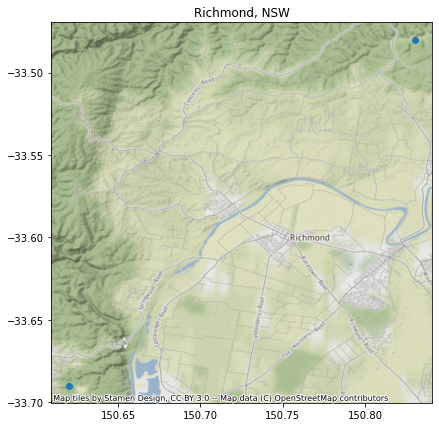

In [2]:
# Richmond, NSW
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat])
cx.add_basemap(ax, crs=crs)
ax.set_title('Richmond, NSW')

#### Creating the Dataframe


##### Loading Frog Response Variable
To train a model, we must first join all predictor variables onto the frog dataframe. The `key` field generated below will make joining easier.



In [3]:
frog_data = (
    pd.read_csv('richmond_frogs.csv')
    .reset_index()
    .rename(columns={'index':'key'})
)
frog_data

,key,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-33.640336,150.687247,1
1,1,-33.609240,150.748344,1
2,2,-33.687430,150.708166,1
3,3,-33.567792,150.790437,1
4,4,-33.629142,150.713045,1
...,...,...,...,...
2907,2907,-33.490500,150.739700,0
2908,2908,-33.540900,150.622100,0
2909,2909,-33.637500,150.647300,0
2910,2910,-33.557700,150.722900,0


##### Loading in Predictor Variables

For this example, we will be combining two datasets for use in our model, JRC and Sentinal-2. To simplify the model, and to assist in later visualisations, we first resize all datasets by a factor of 10. This step will produce the same outcome as if we queried the planetary computer with a resolution of 100 instead of 10. All predictor datasets are collected in a list.

In [4]:
coarsness_factor = np.array([10, 10])

filenames = ['jrc_mosaic_sample.nc', 'S2_mosaic_sample.nc']

all_datasets = []

for file in filenames:
    print(f'loading {file}')
    
    # Read in netcdf4 file to xarray
    data = xr.open_dataset(file).load().to_array()
    
    # Remove time dimension
    data = data[0]
    
    print(f"Shape before (band, y, x): {data.shape}")
    data = data.coarsen(x=coarsness_factor[0], y=coarsness_factor[1], boundary='pad').mean()
    print(f"Shape after (band, y, x): {data.shape}\n")
    
    # Collect all datasets in a list
    all_datasets.append(data)
    
    

loading jrc_mosaic_sample.nc
Shape before (band, y, x): (6, 2339, 2339)
Shape after (band, y, x): (6, 234, 234)

loading S2_mosaic_sample.nc
Shape before (band, y, x): (4, 2339, 2339)
Shape after (band, y, x): (4, 234, 234)



##### Joining Features to Response Variable

Now that we have read in and tidied up our predictor variables of JRC and Sentinel-2, we now need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest pixel values from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here. We write this as a function so that it can be reused later in the notebook.

In [5]:
def join_features(model_data, all_datasets):
    
    for i, data in enumerate(all_datasets):
        # For each latitude and longitude coordinate, find the nearest predictor variable pixel values
        data_per_point = pd.DataFrame()
        for j, (lon, lat, key) in enumerate(zip(model_data.decimalLongitude, model_data.decimalLatitude, model_data.key)):
            # Print out some progress markers
            if j==0:
                print(f"Joining dataset {i+1} of {len(all_datasets)}")
            if (j+1)%500==0:
                print(f"{j+1} of {len(frog_data)}")

            # Get the predictor pixel at the site of the frog occurrence
            nearest_point = data.sel(x=lon, y=lat, method="nearest")
            
            # Prepare values and columns and save them in a dataframe, saving the join key for later reference
            values = np.concatenate((np.squeeze(nearest_point.values), np.array([key])))
            columns = list(nearest_point.band.values) + ['key']
            data_per_point = data_per_point.append(
                pd.DataFrame(
                    np.array([values]), 
                    columns=columns
                )
            )

        # Join the predictor variables we just collected back onto the frog data
        model_data = model_data.merge(
            data_per_point,
            on = ['key'],
            how = 'inner'
        )
        
    return model_data

model_data = join_features(frog_data, all_datasets)
model_data.head()

Joining dataset 1 of 2
500 of 2912
1000 of 2912
1500 of 2912
2000 of 2912
2500 of 2912
Joining dataset 2 of 2
500 of 2912
1000 of 2912
1500 of 2912
2000 of 2912
2500 of 2912


,key,decimalLatitude,decimalLongitude,occurrenceStatus,change,extent,occurrence,recurrence,seasonality,transitions,red,green,blue,nir
0,0,-33.640336,150.687247,1,253.00,0.00,0.00,0.0,0.0,0.00,355.80,342.98,219.50,2040.66
1,1,-33.609240,150.748344,1,253.00,0.00,0.00,0.0,0.0,0.00,400.10,496.34,255.22,2828.38
2,2,-33.687430,150.708166,1,253.00,0.00,0.00,0.0,0.0,0.00,870.26,954.00,612.05,3145.88
3,3,-33.567792,150.790437,1,253.00,0.00,0.00,0.0,0.0,0.00,649.13,778.35,500.70,3227.64
4,4,-33.629142,150.713045,1,217.86,0.14,1.56,12.0,0.0,1.37,557.80,503.13,315.74,2008.20


#### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic Logistic Regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [6]:
from sklearn.linear_model import LogisticRegression

full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['key', 'decimalLongitude', 'decimalLatitude', 'occurrenceStatus'], 1)
)
y = model_data.occurrenceStatus


For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance is crucial in estimating how a model will perform in a real world environment. We will attempt to evaluate the out-of-sample performance of this model in a later section, but for now we can have some fun visualising the in-sample performance for Richmond, NSW.

In [7]:
full_model.fit(X, y)

LogisticRegression()

#### Model Prediction

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To visualise this, we need to understand that each pixel on our satellite image has an associated vector of predictor variable values, in this case 10 bands from JRC and Sentinel-2 data. Thus, we can associate a 10 band image with any satellite image. For each of those 10 band pixels, we can use our linear regression model to output the probability of a frog being found there. Finally, we can visualise this as a heatmap which will show regions that our model thinks are likely frog habitats.


##### Heat Map
As touched on above, to create a probability heat map of the Richmond area we must first generate the 10 band image that our model will use to predict probabilities. To do this, we write two functions. The first function is called `create_predictor_image` and takes in a list of predictor datasets, concatenates their bands together and outputs an xarray of 10-band pixel values.

The second function is called `predict_frogs`, which takes in the multi-band image outputted by the `create_predictor_image` function as well as the trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $10\times n$ array, which is the format required to feed into our linear regression model. Then, the array is fed into the model, returning the model's predictions for the frog likelihood at each pixel. The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows the array to be unstacked and returned as a one-band image, ready for plotting.


In [8]:
def create_predictor_image(all_datasets):
    # Combine datasets into one multi-band image
    for i, data in enumerate(all_datasets):
        print(f"Combining dataset {i+1} of {len(all_datasets)}")
                
        if i == 0:
            combined_values = data.values
            combined_bands = data.band.values
            x_coords = data.x
            y_coords = data.y
            dims = data.dims
        else:
            combined_values = np.concatenate((combined_values, data.values), axis=0)
            combined_bands = np.concatenate((combined_bands, data.band.values))

    predictor_image = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            x=x_coords,
            y=y_coords
        )
    )
    return predictor_image

def predict_frogs(predictor_image, model):
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("x", "y")).transpose()
    
    # Calculate probability for each pixel point 
    probabilities = model.predict_proba(
        predictor_image
    )

    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]

    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [9]:
# Combine datasets into one multi-band image
predictor_image = create_predictor_image(all_datasets)

Combining dataset 1 of 2
Combining dataset 2 of 2


In [10]:
# Calculate probability for each pixel point 
resultant_image = predict_frogs(predictor_image, full_model)

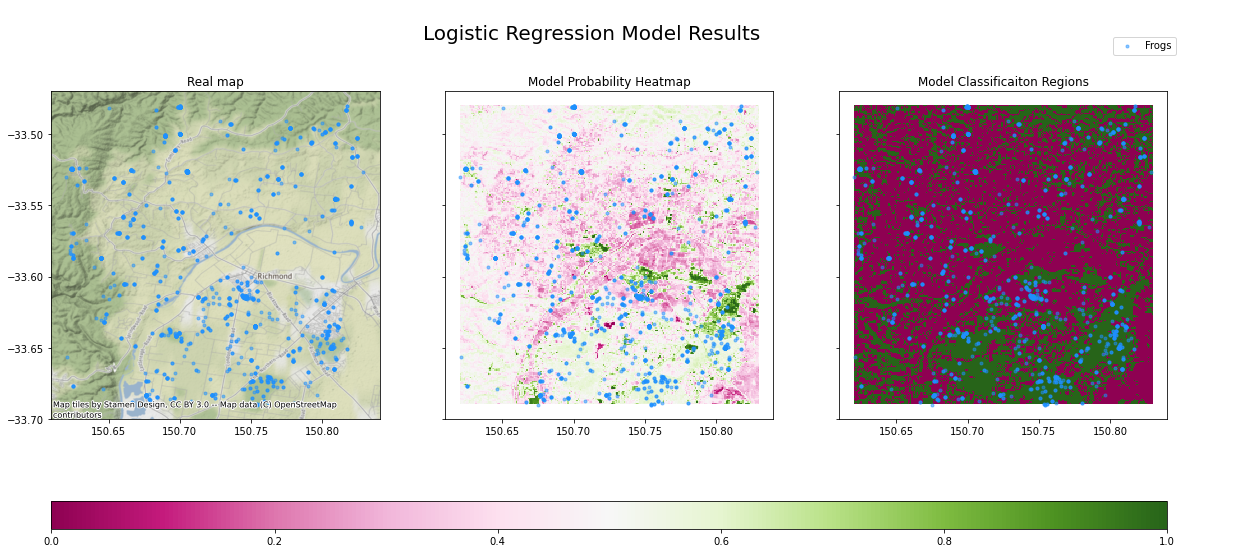

In [11]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    
    bbox = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]

    # Plot real map
    ax[0].scatter(x=[bbox[0], bbox[1]], y=[bbox[2], bbox[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')


    # Plot heatmap from model
    heatmap = ax[1].imshow(
        resultant_image.transpose(), cmap='PiYG', vmin=0, vmax=1.0, interpolation='none',
        extent=[resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    )
    ax[1].set_title('Model Probability Heatmap')


    # Plot binary classification from model
    heatmap = ax[2].imshow(
        resultant_image.transpose() > 0.5, cmap='PiYG', vmin=0, vmax=1.0, interpolation='none',
        extent=[resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    )
    ax[2].set_title('Model Classificaiton Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, color = 'dodgerblue', marker='.', alpha=0.5, label='Frogs' if i==0 else '')

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    

plot_heatmap(resultant_image, frog_data, "Logistic Regression Model Results")

#### In-Sample Evaluation

Now that we have visualised the model on the Richmond area, we can calculate a some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance -  so don't get too excited!


In [12]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

predictions = full_model.predict(X)

print(f"F1 Score: {f1_score(y, predictions)}")
print(f"Accuracy: {accuracy_score(y, predictions)}")

F1 Score: 0.6245224036123654
Accuracy: 0.6287774725274725


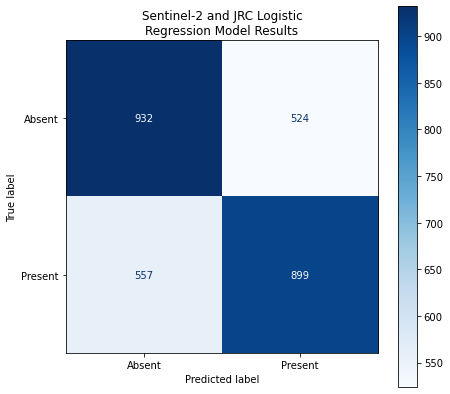

In [13]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Sentinel-2 and JRC Logistic\nRegression Model Results')
plt.show()

#### Out-of-sample evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.


In [14]:
from sklearn.model_selection import StratifiedKFold


cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        results[metric].append(fn(y_test, predictions))
        
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in results.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.59
Accuracy: 0.61


### Testing model on an arbitrary area 

Now that we have generated a model using data from one area, how do we apply that model to other areas? To do this, we need to write some functions that will allow us to automatically pull the required data for an arbitrary location. Specifically, we need to be able to pull all the predictor variables for a given location, as well as the actual frog sightings in that location for reference. These functions will reuse much of the code from prior notebooks, so we won't go into too much detail.

#### Define Functions

In [15]:
def get_frogs(bbox, query_params, crs = {'init':'epsg:4326'}, orderKey="952", verbose=False):
    # Set query parameters
    min_lon, min_lat, max_lon, max_lat = bbox
    limit = 300
    offset = 0
    parameters = {
        **query_params,
        "orderKey":orderKey, # The order Anura (frogs) is indicated by key 952
        "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
        "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
        "limit":limit,
        "offset":offset
    }
    
    # Query API
    frogs = pd.DataFrame()
    while True:
        # Fetch results
        parameters['offset'] = offset
        response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
        total = response['count']
        
        # Print progress
        print(f"{offset} of {total}") if verbose else None
        
        # Add results to dataframe
        frogs = frogs.append(
            pd.DataFrame(response['results'])
            [["decimalLatitude", "decimalLongitude"]]
            .assign(
                occurrenceStatus = '1'
            )
        )
        if response['endOfRecords']:
            break
        offset += limit
        
    geo_frogs = gpd.GeoDataFrame(
        frogs.reset_index(drop=True), 
        geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
        crs=crs
    )
    return geo_frogs


# Function to access the planetary computer
def get_pc(product, bbox, assets={"image/tiff"}, resolution=10, pc_query=None, date_range=None):
    # Query the planetary computer
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print('This is the number of scenes that touch our region:',len(items))
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    # Median Composite
    median = data.median(dim="time").compute()
    return median



#### Query the Hornsby Area

For this, we will use Hornsby, NSW as an example.

Text(0.5, 1.0, 'Berowra Valley National Park, Hornsby NSW')

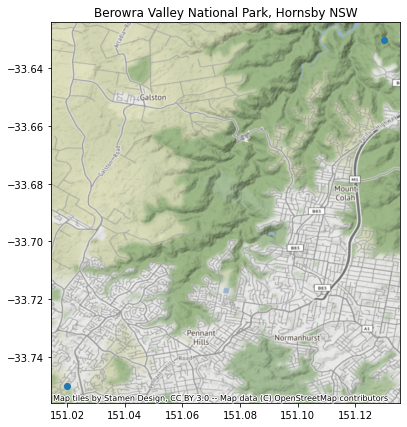

In [16]:
# Hornsby
min_lon, min_lat = (151.02, -33.75)  # Lower-left corner
max_lon, max_lat = (151.13, -33.63)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)


fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat])
cx.add_basemap(ax, crs=crs)
ax.set_title("Berowra Valley National Park, Hornsby NSW")

Firstly, we grab all frog occurrences in the area from 1800 until 2022.

In [17]:
hornsby_frogs = get_frogs(bbox, {"year":"1800,2022"}, verbose=True)

0 of 3001
300 of 3001
600 of 3001
900 of 3001
1200 of 3001
1500 of 3001
1800 of 3001
2100 of 3001
2400 of 3001
2700 of 3001
3000 of 3001


Next, we obtain the predictor variables from the planetary computer, being sure to use a resolution of 100m to ensure the scale aligns with that of our model.

In [18]:
# Define products and query parameters for the planetary computer
products = {
    'jrc-gsw':{
        "resolution":100
    },
    'sentinel-2-l2a':{
        "resolution":100,
        'assets':["B04", "B03", "B02", "B08"],
        'pc_query':{"eo:cloud_cover": {"lt": 20}},
        'date_range':"2020-01-01/2020-12-31"
    }
}

all_datasets = []

for i, (product, params) in enumerate(products.items()):
    print(f'loading {product}')
    data = get_pc(product, bbox, **params)
    
    # Collect all datasets in a list
    all_datasets.append(data)
    

loading jrc-gsw
This is the number of scenes that touch our region: 1
loading sentinel-2-l2a
This is the number of scenes that touch our region: 49


Finally, we can use the `create_predictor_image` and `predict_frogs` functions from before to create the probability heatmap of the new area.

In [20]:
predictor_image = create_predictor_image(all_datasets)
resultant_image = predict_frogs(predictor_image, full_model)

Combining dataset 1 of 2
Combining dataset 2 of 2


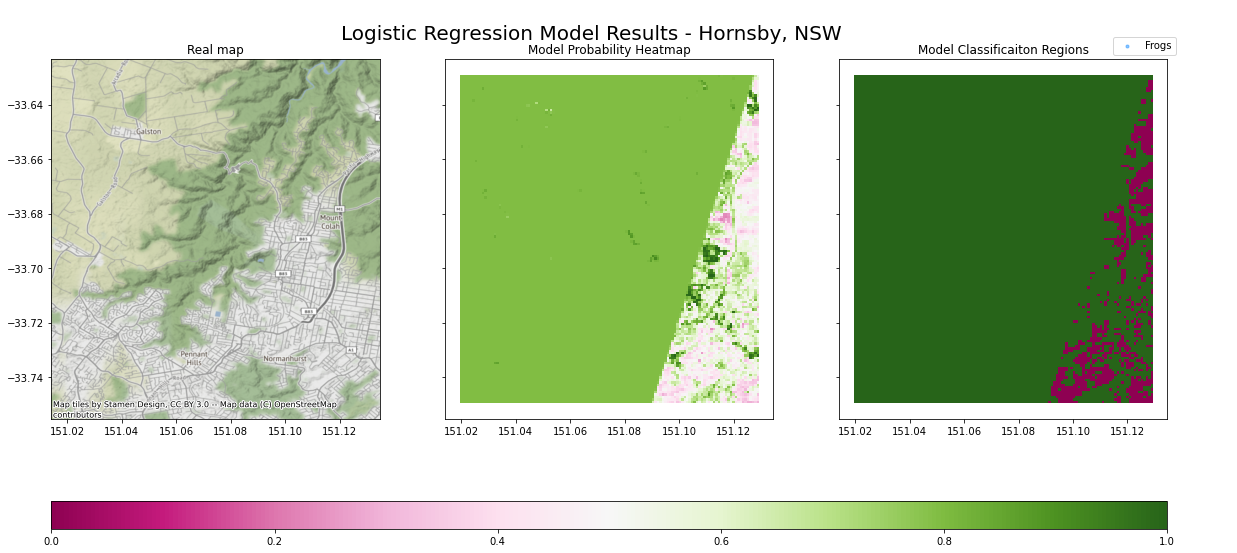

In [21]:
# Display the image
plot_heatmap(resultant_image, hornsby_frogs, "Logistic Regression Model Results - Hornsby, NSW")